In [8]:
import numpy as np

import os
#Choose GPU 0 as a default
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import sys
sys.path.append('/home/zsteineh/cnn_hilbert/cnn_hilbert_workspace')
import hilbert_DL_utils
from hilbert_DL_utils import load_data

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

/home/zsteineh/anaconda3/envs/ez_ss_dl_venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
pretask_type = ['rel_pos', 'sig_tran']
model_types = ['ts', 'pretask', 'tl']
sp = '/home/zsteineh/ez_ssl_results/'
name = pretask_type[0]+model_types[1]+'_acc_dict'
with open(sp+'obj/' + name + '.pkl', 'rb') as f:
        acc_dict = pickle.load(f)

In [3]:
sbj_accs = []
for pretask in pretask_type:
    for model in model_types:
        name = pretask+model+'_acc_dict'
        with open(sp+'obj/' + name + '.pkl', 'rb') as f:
                acc_dict = pickle.load(f)
        for sbj in acc_dict:
            for accs_set in acc_dict[sbj]:
                accs = [pretask, model, sbj]
                for acc in accs_set:
                    accs.append(acc)
                sbj_accs.append(accs)
sbj_acc_df = pd.DataFrame.from_records(sbj_accs, columns = ['Pretask','Model','Subject', 'Train', 'Val', 'Test'])
print(sbj_acc_df)

      Pretask Model   Subject     Train       Val      Test
0     rel_pos    ts  a0f66459  0.944518  0.873016  0.865591
1     rel_pos    ts  a0f66459  0.926024  0.904762  0.841398
2     rel_pos    ts  a0f66459  0.937913  0.888889  0.860215
3     rel_pos    ts  c95c1e82  0.608365  0.446154  0.455556
4     rel_pos    ts  c95c1e82  0.768061  0.630769  0.733333
..        ...   ...       ...       ...       ...       ...
211  sig_tran    tl  ec168864  0.914912  0.862676  0.907609
212  sig_tran    tl  ec168864  0.904386  0.848592  0.913043
213  sig_tran    tl  b45e3f7b  0.780165  0.788079  0.761780
214  sig_tran    tl  b45e3f7b  0.781818  0.754967  0.787958
215  sig_tran    tl  b45e3f7b  0.771074  0.754967  0.738220

[216 rows x 6 columns]


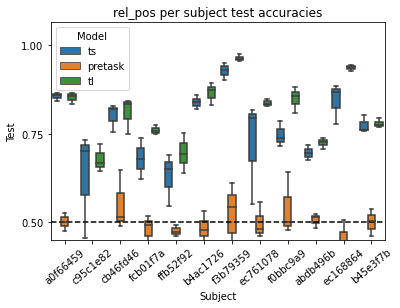

In [4]:
# plot some subject specific stuff
plt = sns.boxplot(x = 'Subject', y = 'Test', hue = 'Model', 
                  data = sbj_acc_df.loc[sbj_acc_df['Pretask'] == pretask_type[0]])
plt.set_xticklabels(plt.get_xticklabels(),rotation=40)
plt.set_title(pretask_type[0]+' per subject test accuracies')
plt.set_ylim([(1/2)-.05,1.065])
plt.set_yticks([.5,.75,1])
plt.axhline(1/2,c='k',linestyle='--')

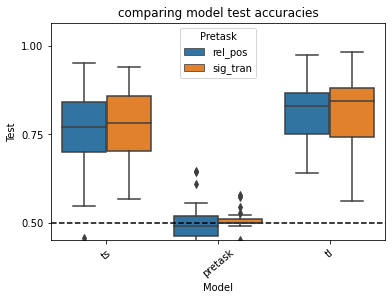

In [17]:
plt = sns.boxplot(x = 'Model', y = 'Test', hue = 'Pretask', data = sbj_acc_df)
plt.set_xticklabels(plt.get_xticklabels(),rotation=40)
plt.set_title('comparing model test accuracies')
plt.set_ylim([(1/2)-.05,1.065])
plt.set_yticks([.5,.75,1])
plt.axhline(1/2,c='k',linestyle='--')

In [15]:
# Kruskal-Wallis test (non-parametric ANOVA)
print(pg.friedman(data=sbj_acc_df, dv='Test', within='Model', subject='Subject')['p-unc'])

# Wilcoxon tests (non-parametric t-tests)
# Computes tests at the data snapshot
p_vals = []
n_models = len(model_types)
for i in range(n_models):
    for j in range(i+1,n_models):
        val1 = sbj_acc_df[(sbj_acc_df['Model'] == model_types[i])].iloc[:,5].values
        val2 = sbj_acc_df[(sbj_acc_df['Model'] == model_types[j])].iloc[:,5].values
        p_vals.append(float(pg.wilcoxon(val1, val2)['p-val']))

# Correct for multiple comparisons
_,p_vals = pg.multicomp(np.asarray(p_vals), alpha=0.05, method='fdr_bh')

pval_df = np.zeros([n_models,n_models])
q = 0
for i in range(n_models):
    for j in range(i+1,n_models):
        pval_df[i,j] = p_vals[q]
        q += 1

# Create output df with p_values
df_pval = pd.DataFrame(pval_df,columns=model_types,index=model_types)
df_pval[df_pval==0] = np.nan
print(df_pval)

Friedman    0.000015
Name: p-unc, dtype: float64
         ts       pretask            tl
ts      NaN  2.540237e-13  7.437682e-07
pretask NaN           NaN  2.540237e-13
tl      NaN           NaN           NaN


In [25]:
# Kruskal-Wallis test (non-parametric ANOVA)
print(pg.friedman(data=sbj_acc_df, dv='Test', within='Pretask', subject='Subject')['p-unc'])
# Looks like this isn't significant between the diff pretasks

Friedman    0.248213
Name: p-unc, dtype: float64


In [29]:
# Wilcoxon tests (non-parametric t-tests)
# Computes tests at the data snapshot
p_vals = []
n_models = len(model_types)
n_pretasks = len(pretask_type)

for pretask in range(n_pretasks):
    print("running model comparison stats for", pretask_type[pretask])
    pretask_df = sbj_acc_df[(sbj_acc_df['Pretask'] == pretask_type[pretask])]
    p_vals = []
    for i in range(n_models):
        for j in range(i+1,n_models):
            val1 = pretask_df[(pretask_df['Model'] == model_types[i])].iloc[:,5].values
            val2 = pretask_df[(pretask_df['Model'] == model_types[j])].iloc[:,5].values
            p_vals.append(float(pg.wilcoxon(val1, val2)['p-val']))

    # Correct for multiple comparisons
    _,p_vals = pg.multicomp(np.asarray(p_vals), alpha=0.05, method='fdr_bh')

    pval_df = np.zeros([n_models,n_models])
    q = 0
    for i in range(n_models):
        for j in range(i+1,n_models):
            pval_df[i,j] = p_vals[q]
            q += 1

    # Create output df with p_values
    df_pval = pd.DataFrame(pval_df,columns=model_types,index=model_types)
    df_pval[df_pval==0] = np.nan
    print(df_pval)

running model comparison stats for rel_pos
         ts       pretask            tl
ts      NaN  2.627513e-07  2.674273e-04
pretask NaN           NaN  2.627513e-07
tl      NaN           NaN           NaN
running model comparison stats for sig_tran
         ts       pretask            tl
ts      NaN  2.629802e-07  8.185175e-04
pretask NaN           NaN  2.629802e-07
tl      NaN           NaN           NaN
